<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/Development/CIFAR_10_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import models, layers
from sklearn.metrics import accuracy_score

In [167]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2021-02-14 15:09:57--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  31.2MB/s    in 5.8s    

2021-02-14 15:10:03 (28.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [168]:
!mkdir ./cifar_10/
!tar -xf cifar-10-python.tar.gz -C ./cifar_10/
!rm -rf cifar-10-python.tar.gz

mkdir: cannot create directory ‘./cifar_10/’: File exists


In [169]:
!ls -l ./cifar_10/cifar-10-batches-py/

total 181876
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [170]:
workdir = os.curdir
datadir = os.path.join(workdir,'cifar_10','cifar-10-batches-py')
train_files = [os.path.join(datadir,f'data_batch_{i}') for i in range(1,6)]
test_file = 'test_batch'

In [171]:
# unpickle the data file containing the image
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [172]:
data_dict = unpickle(train_files[0])
data_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [173]:
# read all files into a dataset
data = np.empty(data_dict[b'data'].shape)
labels = list()
for fl in train_files:
  print(f"Loading File {fl}")
  df = unpickle(fl)
  print(df[b'batch_label'])
  print(f"Geting Data")
  if df[b'batch_label'] == b'training batch 1 of 5':
    data = df[b'data']
  else:
    data = np.concatenate([data,df[b'data']])
  print("Geting labels")
  labels = labels + df[b'labels']
  print(f"Shape of Data is {data.shape}")
  print("="*50)

Loading File ./cifar_10/cifar-10-batches-py/data_batch_1
b'training batch 1 of 5'
Geting Data
Geting labels
Shape of Data is (10000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_2
b'training batch 2 of 5'
Geting Data
Geting labels
Shape of Data is (20000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_3
b'training batch 3 of 5'
Geting Data
Geting labels
Shape of Data is (30000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_4
b'training batch 4 of 5'
Geting Data
Geting labels
Shape of Data is (40000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_5
b'training batch 5 of 5'
Geting Data
Geting labels
Shape of Data is (50000, 3072)


In [174]:
# Reading Metadata
label_meta = unpickle(os.path.join(datadir,'batches.meta'))[b'label_names']
label_meta_mapping = {i:label_meta[i].decode('utf-8') for i in range(len(label_meta))}
label_meta_mapping

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [175]:
labels = np.array(labels)
for i in range(0,10):
  lb_count = np.sum((labels == i)*1)
  print(f"{label_meta_mapping[i]}: {lb_count}")

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


In [176]:
data_rgb = np.reshape(data, (data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

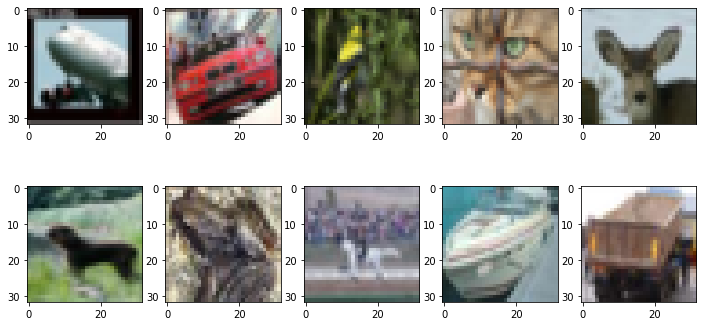

In [177]:
rnd_idx = np.random.randint(1,5000)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
for i in range(10):
  samp = data_rgb[labels == i][rnd_idx,:,:,:]
  ax[int(i/5)][i%5].imshow(samp)

In [178]:
X = data_rgb/255
lb_bin = LabelBinarizer().fit(np.array(labels))
y = lb_bin.transform(np.array(labels))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
#test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.7)
print(f"Training Data Size : {train_X.shape[0]}")
#print(f"Validation Data Size : {val_X.shape[0]}")
print(f"Testing Data Size : {test_X.shape[0]}")

Training Data Size : 40000
Testing Data Size : 10000


In [179]:
def Residual_Layer(input_layer, filters, layer_len, reg, dr):
  print(filters, layer_len)
  # Main Branch
  x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same', kernel_regularizer=reg)(input_layer)
  x = tf.keras.layers.BatchNormalization()(x)

  for i in range(1, layer_len):
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same', kernel_regularizer=reg)(x)
    x = tf.keras.layers.BatchNormalization()(x)

  # Skip Branch
  x1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=(1, 1), strides=1, padding='same', kernel_regularizer=reg)(input_layer)
  x1 = tf.keras.layers.BatchNormalization()(x1)

  # join the 2 branches
  x = tf.keras.layers.add([x, x1])
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
  x = tf.keras.layers.Dropout(dr)(x)
  return x

In [180]:
def define_model(main_layer, reg=None, dr=0.0, dr2=0.0):
  inputs = tf.keras.Input(shape=train_X.shape[1:])
  
  x = tf.keras.layers.Conv2D(32, 7, strides=1, padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

  for filters, layer_len in main_layer:
    x = Residual_Layer(x, filters, layer_len, reg, dr)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dropout(dr2)(x)
  x = tf.keras.layers.Dense(128, kernel_regularizer=reg)(x)
  x = tf.keras.layers.Dropout(dr2)(x)
  x = tf.keras.layers.Dense(64, kernel_regularizer=reg)(x)
  x = tf.keras.layers.Dropout(dr2)(x)
  x = tf.keras.layers.Dense(32, kernel_regularizer=reg)(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  return model

In [181]:
reg = tf.keras.regularizers.L2(l2=0.001)
main_layer = [(64,6), (128,6), (256,6), (512, 8)]
dr = 0.3
dr2 = 0.4
model = define_model(main_layer, reg, dr, dr2)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

64 6
128 6
256 6
512 8
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_258 (Conv2D)             (None, 32, 32, 32)   4736        input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_255 (BatchN (None, 32, 32, 32)   128         conv2d_258[0][0]                 
__________________________________________________________________________________________________
activation_199 (Activation)     (None, 32, 32, 32)   0           batch_normalization_255[0][0]    
____________________________________________________________________

In [182]:
erly_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True,
)

model_monit = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(os.curdir,'Checkpoint.model'), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min'
)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

#exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.01)
val_loss, loss, accuracy, val_accuracy = list(), list(), list(), list()

In [196]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.00001)
history = model.fit(x=train_X, y=train_y, batch_size=256, epochs=50, validation_split=0.15,
                    callbacks=[lr_scheduler, erly_stop, model_monit])
val_loss = val_loss + history.history['val_loss']
val_accuracy = val_accuracy + history.history['val_accuracy']
loss = loss +  history.history['loss']
accuracy = accuracy + history.history['accuracy']

Epoch 1/50
133/133 [==============================] - 11s 80ms/step - loss: 0.5752 - accuracy: 0.9347 - val_loss: 0.9982 - val_accuracy: 0.8210
Epoch 2/50
133/133 [==============================] - 11s 79ms/step - loss: 0.5652 - accuracy: 0.9381 - val_loss: 1.0037 - val_accuracy: 0.8202
Epoch 3/50
133/133 [==============================] - 11s 79ms/step - loss: 0.5607 - accuracy: 0.9391 - val_loss: 1.0110 - val_accuracy: 0.8208
Epoch 4/50
133/133 [==============================] - 11s 79ms/step - loss: 0.5532 - accuracy: 0.9408 - val_loss: 1.0158 - val_accuracy: 0.8227
Epoch 5/50
133/133 [==============================] - 10s 79ms/step - loss: 0.5516 - accuracy: 0.9403 - val_loss: 1.0154 - val_accuracy: 0.8230
Epoch 6/50
133/133 [==============================] - 11s 79ms/step - loss: 0.5449 - accuracy: 0.9415 - val_loss: 1.0183 - val_accuracy: 0.8220
Epoch 7/50
133/133 [==============================] - 11s 79ms/step - loss: 0.5414 - accuracy: 0.9435 - val_loss: 1.0220 - val_accuracy:

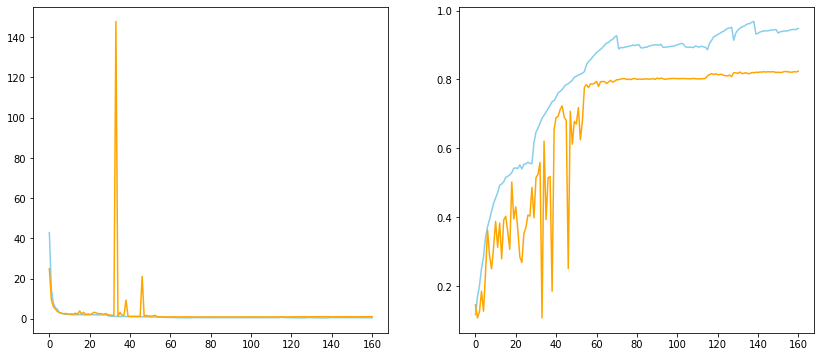

In [197]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
x = list(range(len(val_loss)))

sns.lineplot(x=x, y=loss, ax=ax[0], color='skyblue')
sns.lineplot(x=x, y=val_loss, ax=ax[0], color='orange')

sns.lineplot(x=x, y=accuracy, ax=ax[1], color='skyblue')
sns.lineplot(x=x, y=val_accuracy, ax=ax[1], color='orange')

In [198]:
def top_5_error_rate(predict_proba, y_true):
  result = 0
  for i in range(len(y_true)):
    row = predict_proba[i,:]
    top_5 = sorted(range(len(row)), key = lambda x: row[x], reverse=True)[:5]
    if np.argmax(y_true[i]) in top_5:
      result = result + 1
  
  return result/len(y_true)

In [199]:
proba = model.predict(test_X)
print(f'Accuracy Score : {model.evaluate(test_X, test_y)}')
print(top_5_error_rate(proba, test_y))

313/313 [==============================] - 3s 11ms/step - loss: 1.0112 - accuracy: 0.8191
Accuracy Score : [1.0111867189407349, 0.819100022315979]
0.9796


In [200]:
test_batch = unpickle(os.path.join(datadir,'test_batch'))
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

In [201]:
test_data = np.reshape(test_data, (test_data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

'airplane'

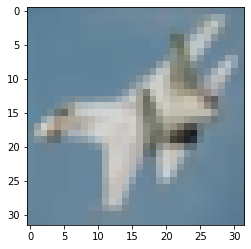

In [202]:
idx = np.random.randint(200)
plt.imshow(test_data[idx])
label_meta_mapping[test_labels[idx]]

In [203]:
proba_test = model.predict(test_data/255)
y_test_bat = lb_bin.transform(np.array(test_labels))
print(f'Accuracy Score : {model.evaluate(test_data/255, y_test_bat)}')
print(top_5_error_rate(proba_test, y_test_bat))

313/313 [==============================] - 3s 11ms/step - loss: 1.0037 - accuracy: 0.8160
Accuracy Score : [1.0037339925765991, 0.8159999847412109]
0.9791


Acutal Label: cat
Predicted Label: cat
{'cat': 0.83091015, 'dog': 0.15147288, 'frog': 0.00763227, 'horse': 0.0045598424}


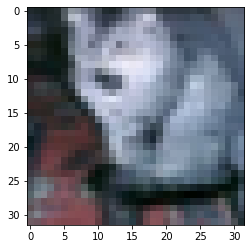

In [231]:
idx = np.random.randint(1000)
prediction = proba_test[idx]
prediction_label = label_meta_mapping[np.argmax(prediction)]
actual = label_meta_mapping[test_labels[idx]]
print(f"Acutal Label: {actual}\nPredicted Label: {prediction_label}")
row = prediction
top_5 = sorted(range(len(row)), key = lambda x: row[x], reverse=True)[:5]
top_5 = [label_meta_mapping[i] for i in top_5]
top_5 = dict(zip(top_5, list(np.sort(prediction))[-1:-5:-1]))
print(top_5)
fig = plt.imshow(test_data[idx])